# This notebook further investigates the domains that were found in the pdb files in Notebook 9.1

In [1]:
import pandas as pd
import sys
import re
import yaml
import os
import regex
import Bio
import matplotlib
import matplotlib.pyplot as plt
import shutil
import multiprocessing as mp
from biopandas.pdb import PandasPdb
from biopandas.pdb.engines import *
from pyRBDome.Classes.PeptideAnalyser import *
from pyRBDome.Functions.RBDomeAnalysisCode import *
from pyRBDome.Classes.DataFileParser import *
from collections import defaultdict
from pathlib import Path
from Bio import SeqIO
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['lines.linewidth'] = 0.75
matplotlib.rcParams['axes.linewidth'] = 0.75
matplotlib.rc('ytick',labelsize=12)
matplotlib.rc('xtick',labelsize=14)
matplotlib.rc('axes',labelsize=18)
%matplotlib inline

### Setting the parameters for the analyses:

In [2]:
settings_file = open('settings.yaml','r')
settings = yaml.load(settings_file,Loader=yaml.FullLoader)

In [3]:
### General parameters:
no_cpus = settings[0]['general']['no_cpus']
pdb_dir = os.path.abspath(settings[0]['general']['pdb_dir'])
out_dir = os.path.abspath(settings[0]['general']['out_dir'])
datafile = os.path.abspath(settings[0]['general']['datafile'])

### Database parameters: 
database_name = settings[4]['database']['database_name']
database_table = settings[4]['database']['database_table']
processed_table = settings[4]['database']['processed_files_log']

### Import InterProScan annotated domain sequences

In [4]:
listTablesFromSQLite(database_name)

['pyrbdome_analysis',
 'distance_analyses_log',
 'rna_bindingsite_analyses_log',
 'MMAlign_RMSD_values',
 'available_pdbs',
 'processed_files_log',
 'rcsb_search_results',
 'InterProScan_Pfam_data',
 'trypsin_in_silico_peptides',
 'Lys_C_in_silico_peptides',
 'random_peptides',
 'trypsin_peptides_with_match_in_pdb',
 'RNA_binding_amino_acids_with_match_in_pdb',
 'lys_C_peptides_with_match_in_pdb',
 'trypsin_amino_acids_with_match_in_pdb',
 'lys_C_amino_acids_with_match_in_pdb',
 'random_amino_acids_with_match_in_pdb',
 'random_peptides_with_match_in_pdb',
 'RNA_binding_peptides_with_match_in_pdb',
 'All_combined_results',
 'Peptides_mapped_to_domains',
 'Amino_acids_mapped_to_domains',
 'interpro_results']

In [5]:
domain_seq = loadTableFromSQLite('InterProScan_Pfam_data',database_name)

Table 'InterProScan_Pfam_data' successfully loaded from database 'pyrbdome_full.db' 


In [6]:
domain_seq.head()

Start  Stop Protein_accession Signature_accession      CL Domain     Id  \
0     73   137       A0AV96_AF_A             PF00076  CL0221    RRM  RRM_1   
1    153   214       A0AV96_AF_A             PF00076  CL0221    RRM  RRM_1   
2    248   311       A0AV96_AF_A             PF00076  CL0221    RRM  RRM_1   
3    134   194       A1L020_AF_A             PF00013  CL0007     KH   KH_1   
4    225   285       A1L020_AF_A             PF00013  CL0007     KH   KH_1   

                                         Description  \
0  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   
1  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   
2  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   
3                                          KH domain   
4                                          KH domain   

                                     Domain_sequence  
0  FVGKIPRDVYEDELVPVFEAVGRIYELRLMMDFDGKNRGYAFVMYC...  
1  FIGGIPKMKKREEILEEIAKVTEGVLDVIVYASAADKMKNRGFAFV...  
2  YVRNLMIETTEDTIKKSFGQFNPGCVERVKKIRDYAFVHFTSREDA...  
3  CVPVPTSEHVAEIVGRQGCKIKALRAKTNTYIKTPVRGEEPVFMVT...  
4  IRVRVPYRVVGLVVGPKGATIKRIQQQTNTYIITPSRDRDPVFEIT...

### 1. The first step is to use the information in this table to cound the occurrence of each domain in the data, using the 'Id' column in the table:

In [7]:
domain_counts = domain_seq['Id'].value_counts()
top_domain_counts = domain_counts[:20]

In [8]:
top_domain_counts

RRM_1             163
KH_1               45
zf-C2H2            35
WD40               24
DEAD               22
Ank_2              20
Helicase_C         20
PUF                16
zf-CCHC            11
RCC1               11
zf-CCCH            10
CSD                 8
zf-NF-X1            6
hEGF                6
ABC_tran            6
S1                  6
HA2                 5
Ribosomal_L7Ae      5
Pkinase             5
SAP                 5
Name: Id, dtype: int64

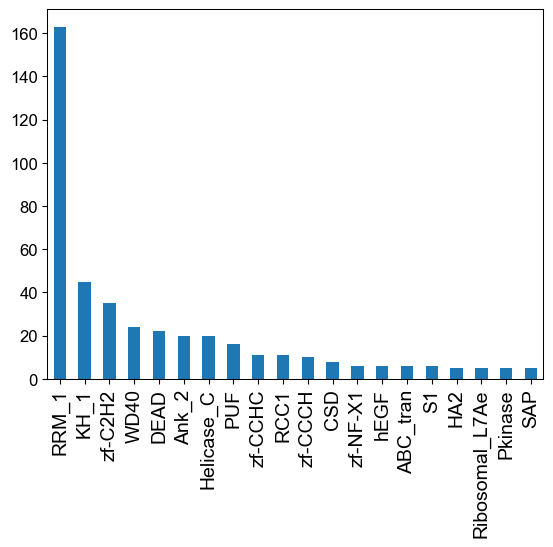

In [9]:
fig,ax = plt.subplots()
top_domain_counts.plot.bar(x=top_domain_counts.values,
                           y=top_domain_counts.index,
                           rot=90,
                           ax=ax)
plt.savefig(f"{out_dir}/Top_domains_barplot.pdf",dpi=400)

### 2. Next thing we want to do is to determine which peptides map to what domains (if any) and we then want to count how frequently a peptide was mapped to a specific domain:

#### Downloading the table with cross-linked peptide information:

In [10]:
mapped_peptides = loadTableFromSQLite('RNA_binding_peptides_with_match_in_pdb',database_name)
mapped_peptides.drop_duplicates(subset='Peptide',inplace=True)

Table 'RNA_binding_peptides_with_match_in_pdb' successfully loaded from database 'pyrbdome_full.db' 


### Removing peptides that were not found in pdb files:

In [11]:
mapped_peptides = mapped_peptides.loc[~mapped_peptides['Found_peptide'].str.contains('not_found')]
mapped_peptides = mapped_peptides.loc[~mapped_peptides['Found_peptide'].str.contains('no_data')]
mapped_peptides = mapped_peptides.loc[:,['ID','pdb_id','chains','Peptide','Found_peptide']]

In [12]:
mapped_peptides.head()

ID     pdb_id chains                    Peptide  \
0  A0AV96  A0AV96_AF      A              GRLLGVCCSVDNC   
1  A0AV96  A0AV96_AF      A  LLGVCCSVDNCRLFIGGIPKMKKRE   
2  A0AV96  A0AV96_AF      A              LGVCCSVDNCRLF   
3  A0AV96  A0AV96_AF      A  LGVCCSVDNCRLFIGGIPKMKKREE   
4  A0AV96  A0AV96_AF      A        GVCCSVDNCRLFIGGIPKM   

                           Found_peptide  
0              139_A_grllgvccsvdnc_151_A  
1  141_A_llgvccsvdncrlfiggipkmkkre_165_A  
2              142_A_lgvccsvdncrlf_154_A  
3  142_A_lgvccsvdncrlfiggipkmkkree_166_A  
4        143_A_gvccsvdncrlfiggipkm_161_A

### Adding a column with information about whether the peptide was mapped to a specific domain:

In [13]:
total_columns = len(mapped_peptides.columns)
mapped_peptides.insert(total_columns,'Domain?','No')

In [14]:
mapped_peptides.head()

ID     pdb_id chains                    Peptide  \
0  A0AV96  A0AV96_AF      A              GRLLGVCCSVDNC   
1  A0AV96  A0AV96_AF      A  LLGVCCSVDNCRLFIGGIPKMKKRE   
2  A0AV96  A0AV96_AF      A              LGVCCSVDNCRLF   
3  A0AV96  A0AV96_AF      A  LGVCCSVDNCRLFIGGIPKMKKREE   
4  A0AV96  A0AV96_AF      A        GVCCSVDNCRLFIGGIPKM   

                           Found_peptide Domain?  
0              139_A_grllgvccsvdnc_151_A      No  
1  141_A_llgvccsvdncrlfiggipkmkkre_165_A      No  
2              142_A_lgvccsvdncrlf_154_A      No  
3  142_A_lgvccsvdncrlfiggipkmkkree_166_A      No  
4        143_A_gvccsvdncrlfiggipkm_161_A      No

### Making a dictionary that for each accession name stores the domain information:

In [15]:
domain_seq.head(3)

Start  Stop Protein_accession Signature_accession      CL Domain     Id  \
0     73   137       A0AV96_AF_A             PF00076  CL0221    RRM  RRM_1   
1    153   214       A0AV96_AF_A             PF00076  CL0221    RRM  RRM_1   
2    248   311       A0AV96_AF_A             PF00076  CL0221    RRM  RRM_1   

                                         Description  \
0  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   
1  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   
2  RNA recognition motif. (a.k.a. RRM, RBD, or RN...   

                                     Domain_sequence  
0  FVGKIPRDVYEDELVPVFEAVGRIYELRLMMDFDGKNRGYAFVMYC...  
1  FIGGIPKMKKREEILEEIAKVTEGVLDVIVYASAADKMKNRGFAFV...  
2  YVRNLMIETTEDTIKKSFGQFNPGCVERVKKIRDYAFVHFTSREDA...

In [16]:
domain_dict = defaultdict(np.array)
domain_information = domain_seq.dropna()
for protein_accession in sorted(set(domain_seq.loc[:,'Protein_accession'])):
    uniprot_id,pdb_name,chains = protein_accession.split("_")
    domains = domain_seq.loc[domain_seq["Protein_accession"] == protein_accession, ['Start','Stop','Id']]    

    converted_data = [tuple(i) for i in domains.values]
    converted_data = np.array(converted_data,dtype='i,i,U200')
    domain_dict[uniprot_id] = converted_data

### Now going through the data for each uniprot_id to ask whether the peptide sequence mapped to any domain:

In [17]:
for i in mapped_peptides.index:
    peptide = mapped_peptides.loc[i,'Found_peptide']
    uniprot_id = mapped_peptides.loc[i,'ID']
    start,chain,sequence,end,_ = peptide.split("_")
    start = int(start)
    end = int(end)
    if uniprot_id in domain_dict:
        protein_domain_data = domain_dict[uniprot_id]
        overlap = numpy_overlap(protein_domain_data,start,end)
        if overlap:
            found_domains = ",".join(overlap)
            mapped_peptides.loc[i,'Domain?'] = found_domains
    else:
        sys.stderr.write(f"No domain information available for Uniprot ID {uniprot_id}.\n")

No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P78527.
No domain information available for Uniprot ID Q14258.
No domain information available for Uniprot ID Q14258.
No domain information available for Uniprot ID Q14258.
No domain information available for Uniprot ID Q3C1V9.
No domain 

In [18]:
mapped_peptides.head()

ID     pdb_id chains                    Peptide  \
0  A0AV96  A0AV96_AF      A              GRLLGVCCSVDNC   
1  A0AV96  A0AV96_AF      A  LLGVCCSVDNCRLFIGGIPKMKKRE   
2  A0AV96  A0AV96_AF      A              LGVCCSVDNCRLF   
3  A0AV96  A0AV96_AF      A  LGVCCSVDNCRLFIGGIPKMKKREE   
4  A0AV96  A0AV96_AF      A        GVCCSVDNCRLFIGGIPKM   

                           Found_peptide Domain?  
0              139_A_grllgvccsvdnc_151_A      No  
1  141_A_llgvccsvdncrlfiggipkmkkre_165_A   RRM_1  
2              142_A_lgvccsvdncrlf_154_A   RRM_1  
3  142_A_lgvccsvdncrlfiggipkmkkree_166_A   RRM_1  
4        143_A_gvccsvdncrlfiggipkm_161_A   RRM_1

### 3. Now that we have this information in a convenient table. We can make another bar plot showing how frequently the peptides mapped to specific domains:

In [19]:
peptide_domain_counts = mapped_peptides['Domain?'].value_counts()
top_peptide_domain_counts = peptide_domain_counts[:20]

In [20]:
top_peptide_domain_counts

No                428
RRM_1             379
KH_1               41
CSD                33
DEAD               16
Helicase_C         15
Ribosomal_L1       11
Ribosomal_L3       10
Ribosomal_S3_C     10
AAA_33              9
Ribosomal_S7e       9
Ribosomal_S8e       9
Ribosomal_S26e      8
Ribosomal_S24e      8
Ribosomal_L13       8
Ribosomal_S5_C      8
zf-CCCH_2           6
Ribosomal_S3Ae      6
KH_2                6
Ribosomal_S9        6
Name: Domain?, dtype: int64

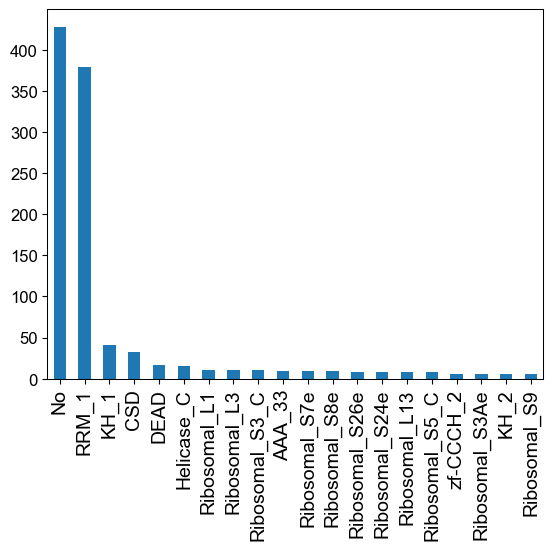

In [21]:
fig,ax = plt.subplots()
top_peptide_domain_counts.plot.bar(x=top_peptide_domain_counts.values,
                                   y=top_peptide_domain_counts.index,
                                   rot=90,
                                   ax=ax)
plt.savefig(f"{out_dir}/Top_peptide_domain_counts_barplot.pdf",dpi=400)

### Uploading the results to SQL:

In [22]:
append = False

In [23]:
if append:
    dataframeToSQLite_append_only_new(mapped_peptides,
                                      'Peptides_mapped_to_domains',
                                      database_name,
                                      filtering_column='ID',
                                      verbose=True)
else: 
    dataframeToSQLite_overwrite(mapped_peptides,
                                'Peptides_mapped_to_domains',
                                database_name)

Table 'Peptides_mapped_to_domains' successfully created in database 'pyrbdome_full.db'! 


### 4. As a final step, we can also now map which cross-linked amino acids mapped to domains. For this we need the table with the amino acids mapped to the structures:

In [24]:
mapped_amino_acids = loadTableFromSQLite('RNA_binding_amino_acids_with_match_in_pdb',database_name)

Table 'RNA_binding_amino_acids_with_match_in_pdb' successfully loaded from database 'pyrbdome_full.db' 


### Removing peptides that were not found in pdb files:

In [25]:
mapped_amino_acids = mapped_amino_acids.loc[~mapped_amino_acids['Found_peptide'].str.contains('not_found')]
mapped_amino_acids = mapped_amino_acids.loc[~mapped_amino_acids['Found_peptide'].str.contains('no_data')]
mapped_amino_acids = mapped_amino_acids.loc[:,['ID','pdb_id','chains','Peptide','Found_peptide']]

In [26]:
mapped_amino_acids.head()

ID     pdb_id chains Peptide  Found_peptide
0  A0AV96  A0AV96_AF      A       C  145_A_c_145_A
1  A0AV96  A0AV96_AF      A       L  153_A_l_153_A
2  A0AV96  A0AV96_AF      A       V  148_A_v_148_A
3  A0AV96  A0AV96_AF      A       F  154_A_f_154_A
4  A0AV96  A0AV96_AF      A       R  152_A_r_152_A

### Adding a column with information about whether the peptide was mapped to a specific domain:

In [27]:
total_columns = len(mapped_amino_acids.columns)
mapped_amino_acids.insert(total_columns,'Domain?','No')

In [28]:
mapped_amino_acids.head()

ID     pdb_id chains Peptide  Found_peptide Domain?
0  A0AV96  A0AV96_AF      A       C  145_A_c_145_A      No
1  A0AV96  A0AV96_AF      A       L  153_A_l_153_A      No
2  A0AV96  A0AV96_AF      A       V  148_A_v_148_A      No
3  A0AV96  A0AV96_AF      A       F  154_A_f_154_A      No
4  A0AV96  A0AV96_AF      A       R  152_A_r_152_A      No

In [29]:
len(mapped_amino_acids.index)

1377

### Now going through the data for each uniprot_id to ask whether the peptide sequence mapped to any domain:

In [30]:
for i in mapped_amino_acids.index:
    peptide = mapped_amino_acids.loc[i,'Found_peptide']
    uniprot_id = mapped_amino_acids.loc[i,'ID']
    start,chain,sequence,end,_ = peptide.split("_")
    start = int(start)
    end = int(end)
    if uniprot_id in domain_dict:
        protein_domain_data = domain_dict[uniprot_id]
        overlap = numpy_overlap(protein_domain_data,start,end)
        if overlap:
            found_domains = ",".join(overlap)
            mapped_amino_acids.loc[i,'Domain?'] = found_domains
    else:
        sys.stderr.write(f"No domain information available for Uniprot ID {uniprot_id}.\n")

No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P43243.
No domain information available for Uniprot ID P78527.
No domain information available for Uniprot ID Q14258.
No domain information available for Uniprot ID Q14258.
No domain information available for Uniprot ID Q14258.
No domain information available for Uniprot ID Q3C1V9.
No domain 

In [31]:
mapped_amino_acids.head()

ID     pdb_id chains Peptide  Found_peptide Domain?
0  A0AV96  A0AV96_AF      A       C  145_A_c_145_A      No
1  A0AV96  A0AV96_AF      A       L  153_A_l_153_A   RRM_1
2  A0AV96  A0AV96_AF      A       V  148_A_v_148_A      No
3  A0AV96  A0AV96_AF      A       F  154_A_f_154_A   RRM_1
4  A0AV96  A0AV96_AF      A       R  152_A_r_152_A      No

In [32]:
amino_acid_domain_counts = mapped_amino_acids['Domain?'].value_counts()
top_amino_acid_domain_counts = amino_acid_domain_counts[:20]

In [33]:
top_amino_acid_domain_counts

No                 512
RRM_1              338
KH_1                35
CSD                 29
DEAD                15
Helicase_C          15
Ribosomal_L1        11
Ribosomal_L3        10
Ribosomal_S3_C      10
AAA_33               9
Ribosomal_S7e        9
Ribosomal_S8e        9
Ribosomal_S26e       8
Ribosomal_L13        8
Ribosomal_S24e       8
zf-CCHC              7
Ribosomal_S5_C       7
NOPS                 6
Ribosomal_S9         6
Methyltransf_10      6
Name: Domain?, dtype: int64

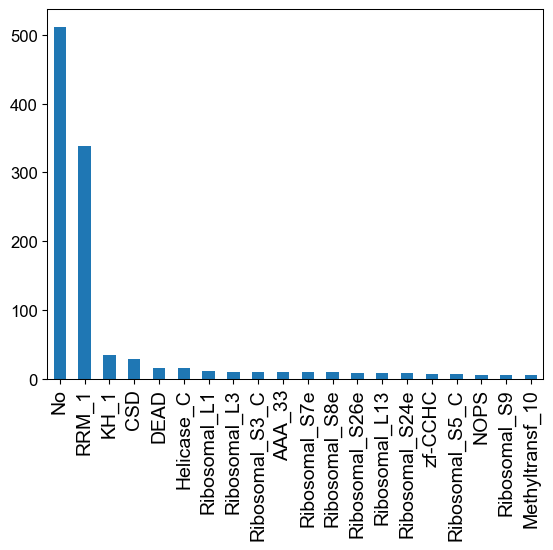

In [34]:
fig,ax = plt.subplots()
top_amino_acid_domain_counts.plot.bar(x=top_amino_acid_domain_counts.values,
                                      y=top_amino_acid_domain_counts.index,
                                      rot=90,
                                      ax=ax)
plt.savefig(f"{out_dir}/Top_amino_acid_domain_counts_barplot.pdf",dpi=400)

### Uploading the results to SQL:

In [35]:
append = False

In [36]:
if append:
    dataframeToSQLite_append_only_new(mapped_amino_acids,
                                      'Amino_acids_mapped_to_domains',
                                      database_name,
                                      filtering_column='ID',
                                      verbose=True)
else: 
    dataframeToSQLite_overwrite(mapped_amino_acids,
                                'Amino_acids_mapped_to_domains',
                                database_name)

Table 'Amino_acids_mapped_to_domains' successfully created in database 'pyrbdome_full.db'! 


# DONE!